In [22]:
import dgl
from dgl.data import PPIDataset
import matplotlib.pyplot as plt
import torch 

In [23]:
train_dataset = PPIDataset(mode='train')
valid_dataset = PPIDataset(mode='valid')
test_dataset = PPIDataset(mode='test')

### Description of PPI Dataset

1. PPI Dataset is an inductive graph, with 24 graphs split into a Train-Test-Validation Split of 20:2:2

In [24]:
print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(valid_dataset)}")
print(f"Number of testing graphs: {len(test_dataset)}")

Number of training graphs: 20
Number of validation graphs: 2
Number of testing graphs: 2


In [25]:
# Checking the first graph 
first_graph = train_dataset[0]
print(f"Number of nodes in the first graph: {first_graph.number_of_nodes()}")
print(f"Number of edges in the first graph: {first_graph.number_of_edges()}")


node_features = first_graph.ndata['feat']
node_labels = first_graph.ndata['label']
print(f"Shape of node features: {node_features.shape}")
print(f"Shape of node labels: {node_labels.shape}")


Number of nodes in the first graph: 1767
Number of edges in the first graph: 34085
Shape of node features: torch.Size([1767, 50])
Shape of node labels: torch.Size([1767, 121])


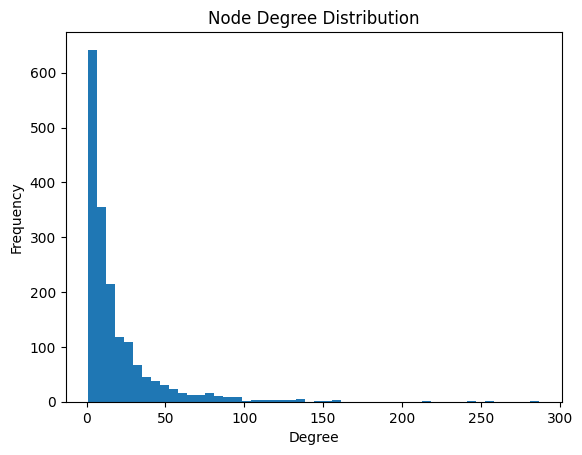

In [26]:
def plot_degree_distribution(graph):
    degrees = graph.in_degrees().numpy()
    plt.hist(degrees, bins=50)
    plt.title('Node Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

# degree distribution for the first graph
plot_degree_distribution(train_dataset[0])

### Global Statistics of all the 24 Graphs 

In [32]:
def inspect_all_graphs_with_sparsity(dataset, dataset_name):
    """Inspect the average number of nodes, edges, and sparsity for each split"""
    total_nodes = 0
    total_edges = 0
    total_graphs = len(dataset)
    sparsity_scores = []
    
    for _, graph in enumerate(dataset):
        num_nodes = graph.number_of_nodes()
        num_edges = graph.number_of_edges()
        total_nodes += num_nodes
        total_edges += num_edges
        
        # sparsity of cur graph 
        if num_nodes > 1:
            sparsity = 1 - (2 * num_edges) / (num_nodes * (num_nodes - 1))
            sparsity_scores.append(sparsity)
    
    # Avergae statistics for each split 
    avg_nodes = total_nodes / total_graphs
    avg_edges = total_edges / total_graphs
    avg_sparsity = sum(sparsity_scores) / len(sparsity_scores) if sparsity_scores else 0
    
    print(f"{dataset_name} dataset statistics:")
    print(f"Average number of nodes: {avg_nodes:.2f}")
    print(f"Average number of edges: {avg_edges:.2f}")
    print(f"Average sparsity: {avg_sparsity:.4f}\n")

inspect_all_graphs_with_sparsity(train_dataset, "Training")
inspect_all_graphs_with_sparsity(valid_dataset, "Validation")
inspect_all_graphs_with_sparsity(test_dataset, "Test")



Training dataset statistics:
Average number of nodes: 2245.30
Average number of edges: 63563.70
Average sparsity: 0.9741

Validation dataset statistics:
Average number of nodes: 3257.00
Average number of edges: 102717.00
Average sparsity: 0.9806

Test dataset statistics:
Average number of nodes: 2762.00
Average number of edges: 83750.00
Average sparsity: 0.9780



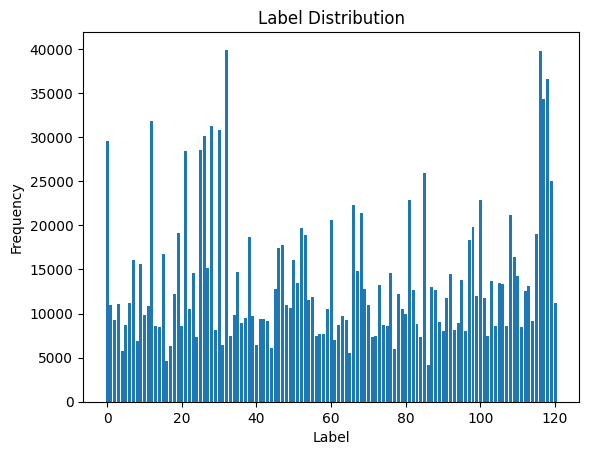

In [28]:
def label_distribution(dataset):
    all_labels = []
    
    for graph in dataset:
        all_labels.append(graph.ndata['label'])
    
    all_labels = torch.cat(all_labels, dim=0)
    label_counts = torch.sum(all_labels, dim=0)
    
    plt.bar(range(len(label_counts)), label_counts.numpy())
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

# label distribution for the training dataset
label_distribution(train_dataset)


### Determining homophlic score for the PPI dataset, for each graph 

In [29]:
def calculate_homophily(graph):

    edges = graph.edges()
    src, dst = edges[0], edges[1]
    
    src_labels = graph.ndata['label'][src]
    dst_labels = graph.ndata['label'][dst]
    
    shared_labels = torch.sum(src_labels * dst_labels, dim=1) > 0
    homophily_score = torch.mean(shared_labels.float()).item()
    
    return homophily_score

def compute_homophily_for_dataset(dataset, dataset_name):
    """Compute homophilic score for all the 24 graphs"""
    homophily_scores = []
    
    for i, graph in enumerate(dataset):
        homophily_score = calculate_homophily(graph)
        homophily_scores.append(homophily_score)
        print(f"Graph {i+1}/{len(dataset)} in {dataset_name} dataset: Homophily score = {homophily_score:.4f}")
    
    return homophily_scores


train_homophily_scores = compute_homophily_for_dataset(train_dataset, "Training")
valid_homophily_scores = compute_homophily_for_dataset(valid_dataset, "Validation")
test_homophily_scores = compute_homophily_for_dataset(test_dataset, "Test")

Graph 1/20 in Training dataset: Homophily score = 0.9754
Graph 2/20 in Training dataset: Homophily score = 0.9740
Graph 3/20 in Training dataset: Homophily score = 0.9753
Graph 4/20 in Training dataset: Homophily score = 0.9766
Graph 5/20 in Training dataset: Homophily score = 0.9758
Graph 6/20 in Training dataset: Homophily score = 0.9818
Graph 7/20 in Training dataset: Homophily score = 0.9760
Graph 8/20 in Training dataset: Homophily score = 0.9762
Graph 9/20 in Training dataset: Homophily score = 0.9782
Graph 10/20 in Training dataset: Homophily score = 0.9696
Graph 11/20 in Training dataset: Homophily score = 0.9737
Graph 12/20 in Training dataset: Homophily score = 0.9792
Graph 13/20 in Training dataset: Homophily score = 0.9760
Graph 14/20 in Training dataset: Homophily score = 0.9649
Graph 15/20 in Training dataset: Homophily score = 0.9791
Graph 16/20 in Training dataset: Homophily score = 0.9723
Graph 17/20 in Training dataset: Homophily score = 0.9744
Graph 18/20 in Training

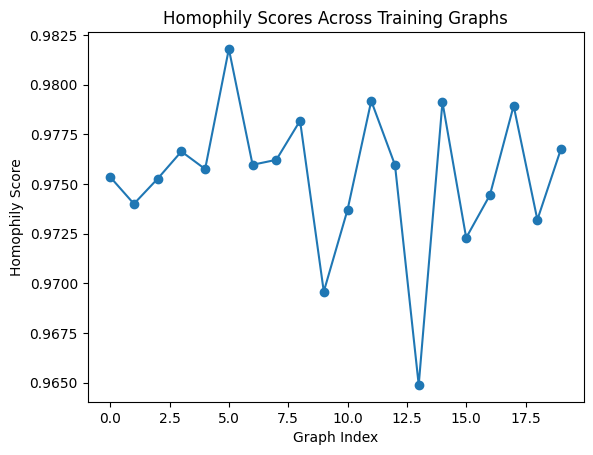

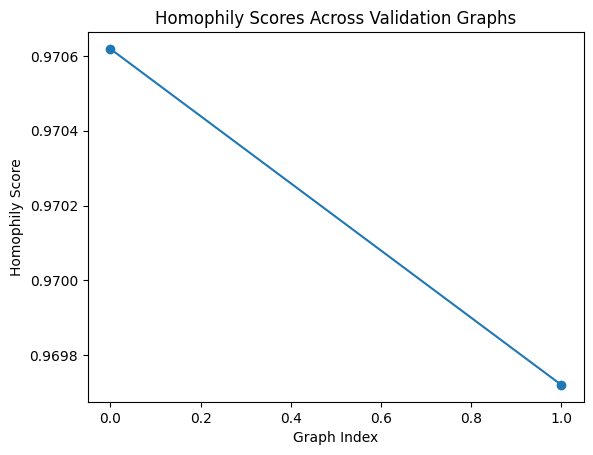

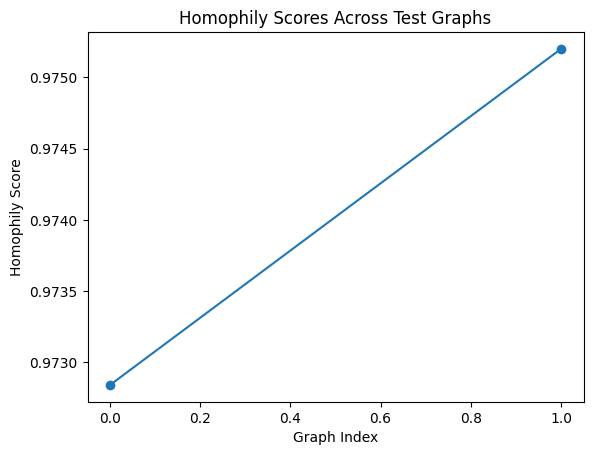

In [30]:
def plot_homophily_scores(scores, title):
    plt.plot(scores, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Graph Index')
    plt.ylabel('Homophily Score')
    plt.show()

plot_homophily_scores(train_homophily_scores, 'Homophily Scores Across Training Graphs')
plot_homophily_scores(valid_homophily_scores, 'Homophily Scores Across Validation Graphs')
plot_homophily_scores(test_homophily_scores, 'Homophily Scores Across Test Graphs')
